## Statistical Analysis

In [184]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib import pyplot as plt
from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

In [114]:
# set global parameters
sns.set(style='darkgrid') 
warnings.filterwarnings('ignore')

In [115]:
# read csv file and print our 5 rows
df = pd.read_excel('C:/GeekBrainsPractice/11_AB_testing/8/homework/AB_Test_Results.xlsx')
display(df.head(5))

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00


In [116]:
# show general info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [117]:
# show stats
df.describe()

,USER_ID,REVENUE
count,10000.00,10000.00
mean,4981.08,0.10
std,2890.59,2.32
min,2.00,0.00
25%,2468.75,0.00
50%,4962.00,0.00
75%,7511.50,0.00
max,10000.00,196.01


In [128]:
# show categories
df['VARIANT_NAME'].unique()

array(['variant', 'control'], dtype=object)

In [118]:
# count duplicate values in USER_ID column
len(df['USER_ID']) - len(df['USER_ID'].drop_duplicates())

3676

In [119]:
# show indices of dublicates
df1 = (df.groupby(df.columns.tolist())
       .apply(lambda x: tuple(x.index))
       .reset_index(name='idx'))
       
dupl_df = df1[df1['idx'].map(len) > 1]
dupl_df.head()

,USER_ID,VARIANT_NAME,REVENUE,idx
0,2,control,0.00,"(2406, 3479, 7076)"
2,3,variant,0.00,"(4145, 7409)"
9,11,control,0.00,"(3889, 8223)"
11,13,control,0.00,"(1156, 6168)"
12,15,variant,0.00,"(458, 5762)"


In [120]:
# total number of duplicates
len(dupl_df)

1777

In [127]:
# filter dataframe with dublicates
filt_df = df[~df['USER_ID'].isin(dupl_df['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
filt_df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,4,variant,0.00
1,5,variant,0.00
2,6,variant,0.00
3,9,variant,0.00
4,10,variant,0.00


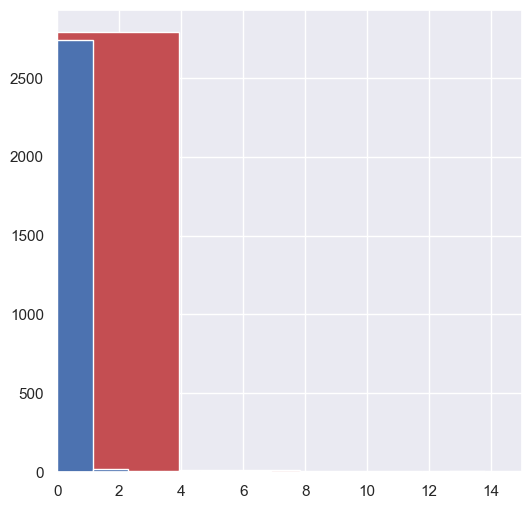

In [153]:
# plot histograms
plt.figure(figsize=(6, 6))
contr_data = filt_df['REVENUE'][filt_df['VARIANT_NAME'] == 'control']
treat_data = filt_df['REVENUE'][filt_df['VARIANT_NAME'] == 'variant']

plt.hist(contr_data, color='r', bins=50, label='Control')
plt.hist(treat_data, bins=50, label='Treatment')

plt.xlim([0, 15])
plt.show()

In [142]:
# count categories
filt_df['VARIANT_NAME'].value_counts()

control    2820
variant    2782
Name: VARIANT_NAME, dtype: int64

In [144]:
# define coefficients (from lecture)
k1 = filt_df[filt_df['VARIANT_NAME'] == 'control']['REVENUE'].sum()
k2 = filt_df[filt_df['VARIANT_NAME'] == 'variant']['REVENUE'].sum()

n1 = filt_df[filt_df['VARIANT_NAME'] == 'control'].shape[0]
n2 = filt_df[filt_df['VARIANT_NAME'] == 'variant'].shape[0]

In [150]:
# calculate stats (from lecture)
z_score, z_pvalue = proportion.proportions_ztest(
    np.array([k1, k2]), np.array([n1, n2])
)
print('z_score: %.3f, pvalue: %.3f'%(z_score, z_pvalue))

z_score: 11.404, pvalue: 0.000


In [163]:
# calculate stats (SciPy lib)
print('stats: %.3f, pvalue: %.3f'%(
    ttest_ind(contr_data, treat_data)[0], 
    ttest_ind(contr_data, treat_data)[1]
))

stats: 1.364, pvalue: 0.173


In [162]:
if abs(ttest_ind(contr_data, treat_data)[1]) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


In [164]:
# non-parametric chi-square (from lecture)
chisq, pvalue, table = proportion.proportions_chisquare(
    np.array([k1, k2]), np.array([n1, n2])
)
print('chisq: %.3f, pvalue: %.3f'%(chisq, pvalue))

chisq: 130.057, pvalue: 0.000


In [181]:
# calculate statistical values
C_mean = contr_data.mean()
T_mean = treat_data.mean()
C_std = contr_data.std()
T_std = treat_data.std()
n = len(contr_data.values)

In [182]:
# calculate effect
S = np.sqrt((T_std ** 2 + C_std ** 2)/ 2)
effect =float((T_mean - C_mean) / S)

In [185]:
# parameters for power analysis
alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(
    effect, 
    power=None,
    nobs1=n, 
    ratio=1.0, 
    alpha=alpha
)
result

0.27861725403457105